In [1]:
import json
import shap
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from tqdm.notebook import tqdm
import ast
import os

/Users/skye.du/opt/anaconda3/envs/ML4ED/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EDIT HERE FOR OTHER COURSES
data_path = '/Volumes/MOOC/flipped/apr21-feature-mooc-flipped/'
week_type = 'eq_week'
feature_types = ['akpinar_et_al', 'boroujeni_et_al', 
                 'chen_cui', 'he_et_al', 'lalle_conati','lemay_doleck', 
                 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']
course = 'epfl_algebrelineaire'
marras_et_al_id = feature_types.index('marras_et_al')
akpinar_et_al_id = feature_types.index('akpinar_et_al')
remove_obvious = True

## Loading the features and their names

In [3]:
# function that replaces NaNs with the minimum of that feature over all weeks
def fillNaN(feature):
    shape = feature.shape
    feature_min = np.nanmin(
        feature.reshape(-1, shape[2]), axis=0
    )  # min of that feature over all weeks
    feature = feature.reshape(-1, shape[2])
    inds = np.where(np.isnan(feature))
    feature[inds] = np.take(feature_min.reshape(-1), inds[1])
    feature = feature.reshape(shape)
    return feature

In [4]:
# Loading the features used in training in the biLSTM with loading the json file made in the biLSTM training notebook.
file = 'selected_features/' + course + '_after.json'
with open(file, 'r') as f:
    selected_features = json.load(f)

In [5]:
def clean_name(feature):
    id = feature.find('<')
    if id==-1:
        return feature
    fct = feature[id+9:id+14].strip()
    return feature[0:id]+fct

In [6]:
# Loading the features
feature_list = {}

feature_type_list = []
for feature_type in feature_types:

    filepath = data_path + week_type + '-' + feature_type + '-' + course
    feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
    print(feature_current.shape)
    feature_norm = feature_current.reshape(-1,feature_current.shape[2] )
    print(feature_norm.shape)
    feature_type_list.append(pd.DataFrame(feature_norm))
feature_list[course] = feature_type_list

print('course: ', course)
print('week_type: ', week_type)
print('feature_type: ', feature_types)

(214, 14, 347)
(2996, 347)
(214, 14, 3)
(2996, 3)
(214, 14, 13)
(2996, 13)
(214, 14, 3)
(2996, 3)
(214, 14, 22)
(2996, 22)
(214, 14, 10)
(2996, 10)
(214, 14, 12)
(2996, 12)
(214, 14, 3)
(2996, 3)
(214, 14, 13)
(2996, 13)
(214, 14, 14)
(2996, 14)
course:  epfl_algebrelineaire
week_type:  eq_week
feature_type:  ['akpinar_et_al', 'boroujeni_et_al', 'chen_cui', 'he_et_al', 'lalle_conati', 'lemay_doleck', 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']


In [7]:
# Loading feature names
feature_names= dict()

for feature_type in feature_types:
    
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/settings.txt'
    file = open(filepath, "r")
    contents = file.read()
    dictionary = ast.literal_eval(contents)
    file.close()
    
    feature_type_name = dictionary['feature_names']
    if feature_type == 'akpinar_et_al': 
        akp_mask = np.where(np.isin(feature_type_name, 
                 ["TotalClicks", "NumberSessions", "Time-video-sum", "Time-problem-sum",
                  'problem.check-problem.check-problem.check', 
                  'problem.check-problem.check-video.load', 
                  'video.play-video.play-video.play',
                  'video.play-video.pause-video.load',
                  'video.play-problem.check-problem.check',
                  'video.play-video.stop-video.play',
                  'video.pause-video.speedchange-video.play',
                  'video.stop-video.play-video.seek',
                  'video.stop-problem.check-video.load']))
    #     print(akp_mask)
        feature_type_name = list(np.array(feature_type_name)[akp_mask[0]])
        feature_list[course][akpinar_et_al_id] = feature_list[course][akpinar_et_al_id][akp_mask[0]]
        
    feature_names[feature_type] = feature_type_name
    print(feature_type, len(feature_type_name))

if remove_obvious: 
    # drop 'student shape', 'competency strength', 'competency alignment' in marras at al
    
    mask = np.where(np.isin(feature_names['marras_et_al'], 
                 ['StudentShape', 'CompetencyStrength', 'CompetencyAlignment']))
    
    new_marras = np.delete(np.array(feature_names['marras_et_al']), mask[0])
    feature_names['marras_et_al'] = new_marras
    
    new_features = feature_list[course][marras_et_al_id].drop(mask[0], axis=1)
    feature_list[course][marras_et_al_id] = new_features


akpinar_et_al 13
boroujeni_et_al 9
chen_cui 13
he_et_al 3
lalle_conati 22
lemay_doleck 10
marras_et_al 12
mbouzao_et_al 3
mubarak_et_al 14
wan_et_al 14


In [8]:
for k in feature_names.keys():
    cleaned = [clean_name(x) for x in feature_names[k]]
    feature_names[k] = cleaned

In [9]:
def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

def load_features(course):
    feature_list = []
    selected_features = []
    total_features = set()
    num_weeks = 0
    num_features = 0
    for i,feature_type in enumerate(feature_types):
        filepath = data_path + week_type + '-' + feature_type + '-' + course 
        feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
        
        shape = feature_current.shape
#         print(shape)

        if remove_obvious and feature_type=='marras_et_al':
            feature_current = np.delete(feature_current, [0,1,6], axis=2)
        
        if feature_type=='akpinar_et_al':
            akp_mask_dl = np.delete(list(range(shape[2])), akp_mask[0])
            feature_current = np.delete(feature_current, akp_mask_dl, axis=2)
        
        shape = feature_current.shape
        print(shape)
        if i==0:
            num_weeks = shape[1]
            
        selected = np.arange(shape[2])
        # drop existed features
        exist_mask = []
        for i, name in enumerate(feature_names[feature_type]):
            if name in total_features:
                exist_mask.append(i)
            else:
                total_features.add(name)
        feature_current = np.delete(feature_current, exist_mask, axis=2)
        selected = np.delete(selected, exist_mask)
        
        nonNaN = (shape[0]*shape[1] - np.isnan(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0) > 0)
        feature_current = feature_current[:,:,nonNaN]
        selected = selected[nonNaN]
        feature_current = fillNaN(feature_current)
        nonZero = (abs(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0)>0)
        selected = selected[nonZero]
        feature_current = feature_current[:,:,nonZero]
#         print(len(feature_names[feature_type]), selected)
        selected_features.append(np.array(feature_names[feature_type])[[selected]])
        num_features += len(np.array(feature_names[feature_type])[[selected]])


        ##### Normalization with min-max. Added the artifical 1.001 max row for solving the same min max problem
        ##### for features with max=0 I added 1 instead of 1.001 of maximum

        features_min = feature_current.min(axis=0).reshape(-1)
        features_max = feature_current.max(axis=0)
        features_max = np.where(features_max==0,np.ones(features_max.shape),features_max)
        max_instance = 1.001*features_max
        feature_current = np.vstack([feature_current,max_instance.reshape((1,)+max_instance.shape)])
        features_max = features_max.reshape(-1)
        feature_norm = (feature_current.reshape(shape[0]+1,-1)-features_min)/(1.001*features_max-features_min)
        feature_current = feature_norm.reshape(-1,feature_current.shape[1],feature_current.shape[2] )

        feature_list.append(feature_current)
        
    features = np.concatenate(feature_list, axis=2)
    features_min = features.min(axis=0).reshape(-1)
    features_max = features.max(axis=0)
    features = features.reshape(features.shape[0],-1)
    features = pd.DataFrame(features)
    
    SHAPE = features.shape
    # print(np.isnan(features[0,0,-1]))
    print(features.shape)
    print('course: ', course)
    print('week_type: ', week_type)
    print('feature_type: ', feature_types)
    print(selected_features)
    return features, features_min, features_max, selected_features, num_weeks, num_features


In [10]:
y = load_labels(course)

In [11]:
features, features_min, features_max, selected_features, num_weeks, num_features = load_features(course)

(214, 14, 13)
(214, 14, 3)
(214, 14, 13)
(214, 14, 3)
(214, 14, 22)
(214, 14, 10)
(214, 14, 9)


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(214, 14, 3)
(214, 14, 13)
(214, 14, 14)
(215, 1148)
course:  epfl_algebrelineaire
week_type:  eq_week
feature_type:  ['akpinar_et_al', 'boroujeni_et_al', 'chen_cui', 'he_et_al', 'lalle_conati', 'lemay_doleck', 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']
[array(['TotalClicks', 'NumberSessions', 'Time-video-sum',
       'Time-problem-sum', 'video.pause-video.speedchange-video.play',
       'video.play-video.pause-video.load',
       'video.play-video.play-video.play',
       'video.play-video.stop-video.play',
       'video.play-problem.check-problem.check',
       'video.stop-video.play-video.seek',
       'video.stop-problem.check-video.load',
       'problem.check-problem.check-video.load',
       'problem.check-problem.check-problem.check'], dtype='<U41'), array(['RegPeakTime-m1', 'RegPeriodicity-m1', 'DelayLecture'],
      dtype='<U17'), array(['TimeSessions-sum', 'TimeSessions-mean', 'TimeBetweenSessions-std',
       'TimeSessions-std', 'TotalClicks-weekday', 'T

In [12]:
# calculate the number of features
n_features = sum([len(x) for x in selected_features])
n_features

82

In [13]:
# Loading feature names and transforming them to 2D format.
feature_names= []
final_features = []
for i, feature_type in enumerate(feature_types):
    [final_features.append(x) for x in selected_features[i]]
for i in np.arange(num_weeks):
    feature_type_name_with_weeks = [(x+'_InWeek'+str(i+1)) for x in final_features]
    feature_names.append(feature_type_name_with_weeks)
feature_names = np.concatenate(feature_names, axis=0)
feature_names = feature_names.reshape(-1)
# print(feature_names)
features.columns = feature_names

In [14]:
# This block loads number of features in each feature set.
num_feature_type = []
for i, feature_type in enumerate(feature_types):
    num_feature_type.append(len(selected_features[i]))
print(num_feature_type)

[13, 3, 7, 3, 17, 10, 9, 1, 7, 12]


## Making a predict_proba:

Here we take the Keras model trained in its respective notebook 
and explain why it makes different predictions for different individuals. 
SHAP expects model functions to take a 2D numpy array as input, 
so we define a wrapper function around the original Keras predict function.



In [15]:
# This module transforms our data to the 2D format biLSTM was trained with.
def transform_x(x, num_feature_type, num_weeks, normal=True):
    try:
        r = np.array(x).reshape((x.shape[0],x.shape[1]))
    except IndexError:
        r = np.array(x).reshape((1,-1))
    return r

In [16]:
# EDIT HERE FOR OTHER MODELS
model_name = "../models/lstm_bi_"+course
loaded_model = keras.models.load_model(model_name)

2022-05-08 15:35:41.957083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 15:35:43.070886: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-05-08 15:35:44.635415: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-05-08 15:35:45.162343: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes m

In [17]:
predict_fn = lambda x: loaded_model.predict(transform_x(x,num_feature_type,num_weeks)).flatten()

# Explaining biLSTM using SHAP:

## Modules for visualization:

In [18]:
def forceplot_all(shap_values,instances,features,real_labels,algorithm,group,max_display=10,show=True,explainer=None):
    for i,inst in enumerate(instances):
        print(inst)
        s='fail' if real_labels[inst] else 'pass'
        p=predict_fn(features.iloc[inst,:])
        title = ("Force plot for instance number {i:d} ".format(i=inst))+("with real label {}".format(s)+'({:.4f})'.format(p[0]))
        print(title)
        if (algorithm == 'p'):
            force = shap.force_plot(shap_values.base_values[i], shap_values.values[i], features.iloc[inst],contribution_threshold=0.05)
            shap.save_html("uniform_eq_results/SHAP/" + course + "/Permutation/plots/forceplots/"+str(inst)+".html", force)
        else:
            force = shap.force_plot(explainer.expected_value, shap_values[i], features.iloc[inst],contribution_threshold=0.05)
            shap.save_html("uniform_eq_results/SHAP/" + course + "/Kernel/plots/forceplots/"+str(inst)+".html", force)
    return


In [23]:
# Plots an explantion of a single prediction as a waterfall plot.
# 
'''The SHAP value of a feature represents the impact of the evidence provided by that feature on the model’s output. 
The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature move the model output 
from our prior expectation under the background data distribution, 
to the final model prediction given the evidence of all the features. 
Features are sorted by the magnitude of their SHAP values with the smallest magnitude features grouped together 
at the bottom of the plot when the number of features in the models exceeds the max_display parameter.'''
# 

def waterfall_all(shap_values,instances,features,real_labels,group,max_display=10,show=True):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    for i,inst in enumerate(instances):
        s='fail' if real_labels[inst] else 'pass'
        p=predict_fn(features.iloc[inst,:])
        title = ("Waterfall plot for instance number {i:d} ".format(i=inst))+("with real label {}".format(s)+'({:.4f})'.format(p[0]))
        plt.title(title)
        fig = shap.plots.waterfall(shap_values[i], max_display=max_display, show=False)  
#         if show:
#             plt.show()
        plt.savefig("./uniform_eq_results/SHAP/" + course +"/Permutation/plots/waterfalls/"+str(inst)+".png", bbox_inches = 'tight')
    return


# Instances chosen by SP-LIME:


In [20]:
# Loading the splime instances
num_instances = np.load('uniform_data/uniform_'+course+'.npy')

## permutation SHAP:

In [21]:
Background_distribution = shap.utils.sample(features, 100)
instances = features.iloc[num_instances]
explainer = shap.PermutationExplainer(predict_fn, Background_distribution)
shap_values = explainer(instances, max_evals=5000)

Permutation explainer: 101it [1:27:32, 52.53s/it]                               


In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
# waterfall_all(shap_values,num_instances,features,y,'r',max_display=15)

In [25]:
shaps = [[0.0 if np.isnan(x) else x for x in s] for s in shap_values.values]

shap.initjs()
forceplot_all(shap_values,num_instances,features,y,'p','r',max_display=15)

15
Force plot for instance number 15 with real label fail(0.9157)
139
Force plot for instance number 139 with real label fail(0.8162)
134
Force plot for instance number 134 with real label fail(0.8834)
110
Force plot for instance number 110 with real label fail(0.8928)
57
Force plot for instance number 57 with real label fail(0.9210)
185
Force plot for instance number 185 with real label fail(0.9109)
117
Force plot for instance number 117 with real label fail(0.8843)
84
Force plot for instance number 84 with real label fail(0.8777)
79
Force plot for instance number 79 with real label fail(0.7992)
46
Force plot for instance number 46 with real label fail(0.9060)
155
Force plot for instance number 155 with real label fail(0.9251)
28
Force plot for instance number 28 with real label fail(0.8556)
111
Force plot for instance number 111 with real label fail(0.9019)
208
Force plot for instance number 208 with real label fail(0.7794)
13
Force plot for instance number 13 with real label fail(0.

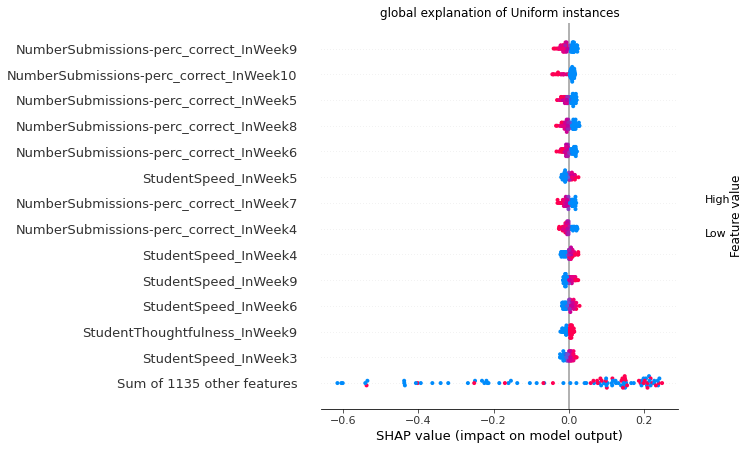

['NumberSubmissions-perc_correct_InWeek9', 'NumberSubmissions-perc_correct_InWeek10', 'NumberSubmissions-perc_correct_InWeek5', 'NumberSubmissions-perc_correct_InWeek8', 'NumberSubmissions-perc_correct_InWeek6', 'StudentSpeed_InWeek5', 'NumberSubmissions-perc_correct_InWeek7', 'NumberSubmissions-perc_correct_InWeek4', 'StudentSpeed_InWeek4', 'StudentSpeed_InWeek9']


In [26]:
shap.plots.beeswarm(shap_values, max_display=14,show=False)
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.title('global explanation of Uniform instances')
plt.savefig("./uniform_eq_results/SHAP/"+course+"/Permutation/plots/global/"+"summaryplot.png", bbox_inches = 'tight')
plt.show()
labels = labels[::-1]
top_features=[]
for i in np.arange(len(labels)):
    x=labels[i]
    top_features.append(x.get_text())
print(top_features[:10])
file = './uniform_eq_results/SHAP/'+course+'/Permutation/plots/top_features_permutation_splime.json'
with open(file, 'w') as f: 
    json.dump(top_features, f)

Create a bar plot of a set of SHAP values. \
If a single sample is passed then we plot the SHAP values as a bar chart. If an Explanation with many samples is passed then we plot the mean absolute value for each feature column as a bar chart.


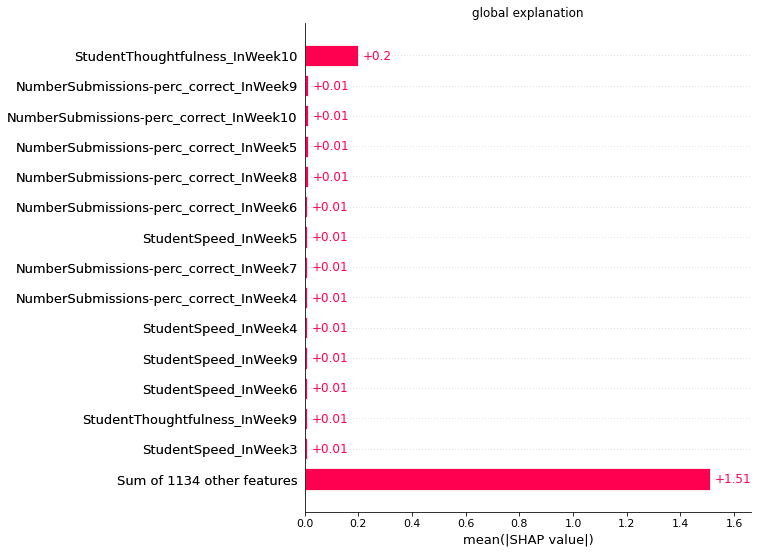

In [27]:
'''Create a bar plot of a set of SHAP values.
If a single sample is passed then we plot the SHAP values as a bar chart. 
If an Explanation with many samples is passed then we plot the mean absolute value for each feature column as a bar chart.'''

fig = shap.plots.bar(shap_values,max_display=15,show=False)
plt.title('global explanation')
plt.savefig("./uniform_eq_results/SHAP/" + course + "/Permutation/plots/global/"+"barplot.png", bbox_inches = 'tight')
plt.show()

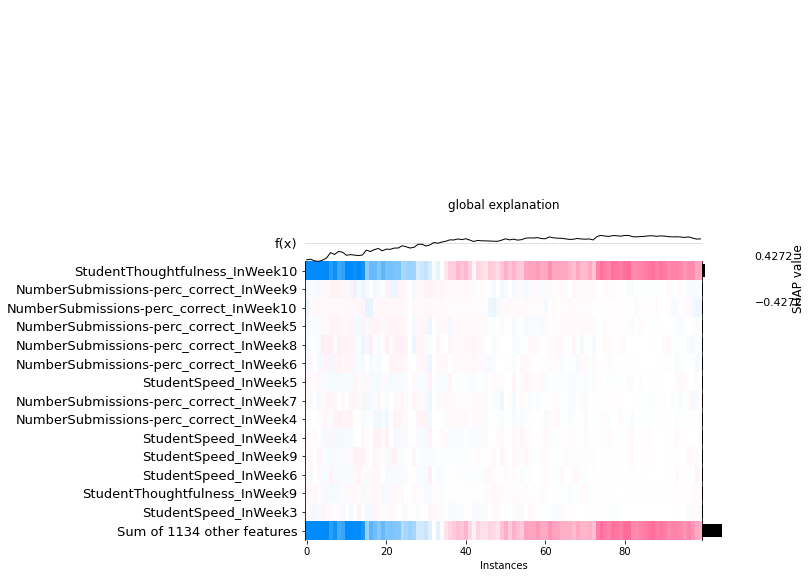

In [28]:
fig = shap.plots.heatmap(shap_values,max_display=15,show=False)
plt.title('global explanation')
plt.savefig("./uniform_eq_results/SHAP/"+course+"/Permutation/plots/global/heatmap.png", bbox_inches = 'tight')
plt.show()

In [29]:
shap.initjs()
force = shap.force_plot(shap_values.base_values[0], shap_values.values, features.iloc[num_instances],contribution_threshold=0.05)
shap.save_html("./uniform_eq_results/SHAP/" + course + "/Permutation/plots/global/"+"forceplot_for_all.html", force)


In [30]:
# saving SHAP values in dataframe
df_shap = pd.DataFrame(shap_values.values, columns = features.columns)
df_shap.insert(0, 'exp_num', num_instances)
df_shap.to_csv('uniform_eq_results/SHAP/Permutation/' + course + '.csv')

### Kernel shap:

In [31]:
''' 
Uses the Kernel SHAP method to explain the output of any function.
Kernel SHAP is a method that uses a special weighted linear regression to compute the importance of each feature. 
The computed importance values are Shapley values from game theory and also coefficents from a local linear regression.
You can find this algorithm's details on https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap 
'''
explainer = shap.KernelExplainer(predict_fn, Background_distribution)
instances = features.iloc[num_instances]
shap_values = explainer.shap_values(instances)


  0%|                                                   | 0/100 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  1%|▍                                        | 1/100 [00:55<1:31:52, 55.68s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 12%|████▊                                   | 12/100 [12:45<1:40:03, 68.22s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 13%|█████▏                                  | 13/100 [13:55<1:40:01, 68.98s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 24%|█████████▌                              | 24/100 [26:32<1:26:21, 68.18s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 25%|██████████                              | 25/100 [27:39<1:24:51, 67.88s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 36%|██████████████▍                         | 36/100 [39:51<1:11:39, 67.18s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 37%|██████████████▊                         | 37/100 [41:00<1:10:54, 67.53s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 48%|████████████████████▏                     | 48/100 [53:35<59:55, 69.15s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 49%|████████████████████▌                     | 49/100 [54:44<58:45, 69.14s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 60%|████████████████████████                | 60/100 [1:07:15<44:26, 66.66s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 61%|████████████████████████▍               | 61/100 [1:08:23<43:30, 66.93s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 72%|████████████████████████████▊           | 72/100 [1:21:05<31:33, 67.61s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 73%|█████████████████████████████▏          | 73/100 [1:22:11<30:15, 67.24s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 84%|█████████████████████████████████▌      | 84/100 [1:34:31<17:49, 66.87s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 85%|██████████████████████████████████      | 85/100 [1:35:44<17:12, 68.81s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

 96%|██████████████████████████████████████▍ | 96/100 [1:47:41<04:23, 65.90s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 97%|██████████████████████████████████████▊ | 97/100 [1:48:48<03:18, 66.20s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

In [32]:
df_shap = pd.DataFrame(shap_values, columns = features.columns)
df_shap.insert(0, 'exp_num', num_instances)
df_shap.to_csv('uniform_eq_results/SHAP/' + course + '/kernel/' + course + '.csv')


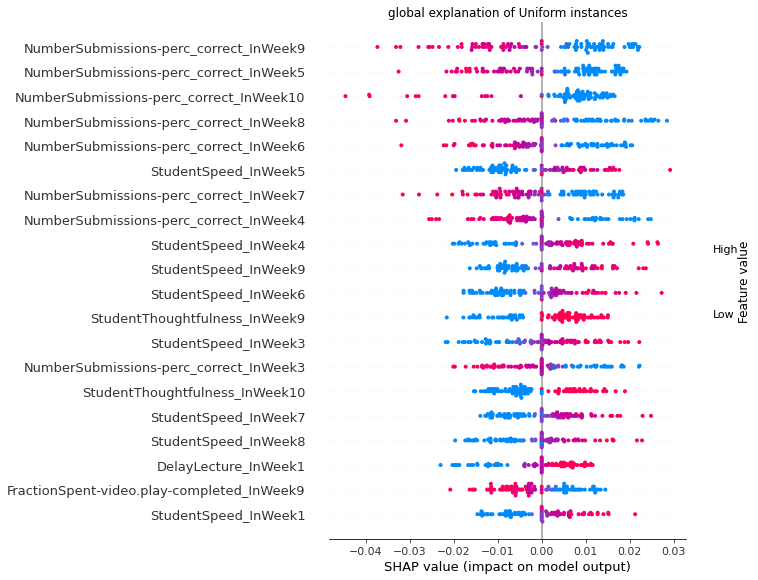

['NumberSubmissions-perc_correct_InWeek9', 'NumberSubmissions-perc_correct_InWeek5', 'NumberSubmissions-perc_correct_InWeek10', 'NumberSubmissions-perc_correct_InWeek8', 'NumberSubmissions-perc_correct_InWeek6', 'StudentSpeed_InWeek5', 'NumberSubmissions-perc_correct_InWeek7', 'NumberSubmissions-perc_correct_InWeek4', 'StudentSpeed_InWeek4', 'StudentSpeed_InWeek9']


In [33]:
fig = shap.summary_plot(shap_values, instances,show=False)
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.title('global explanation of Uniform instances')
plt.savefig("./uniform_eq_results/SHAP/"+course+"/kernel/plots/global/"+"summaryplot.png", bbox_inches = 'tight')
plt.show()
labels = labels[::-1]
top_features=[]
for i in np.arange(len(labels)):
    x=labels[i]
    top_features.append(x.get_text())
print(top_features[:10])
file = "./uniform_eq_results/SHAP/"+course+"/kernel/plots/top_features_kernel_uniform.json"
with open(file, 'w') as f: 
    json.dump(top_features, f)